In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import keras

2023-11-17 19:01:55.911063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 19:01:56.193947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 19:01:56.194024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 19:01:56.195229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 19:01:56.341020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 19:01:56.342966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
df = pd.read_csv('./datasets/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
X = df.iloc[:, 3:-1]
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [7]:
y = df.iloc[:, -1]
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

**Converting Categorical to Numerical for using in model -> Geography, Gender**

**We are treating countries with ordinal values(0 < 1 < 2) but they are incomparable.** 
**To solve this we can use one hot encoding. We will perform some standardization**

In [10]:
X['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [13]:
geography = pd.get_dummies(X['Geography'], dtype=int)
gender = pd.get_dummies(X['Gender'], dtype=int)

display(geography)
display(gender)

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


,Female,Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,1,0
9998,0,1


In [15]:
X = pd.concat([X, geography, gender], axis=1)

In [16]:
X.drop(columns=['Geography','Gender'], axis=1, inplace=True)

In [17]:
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.2)

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [141]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [142]:
classifier = Sequential()

In [143]:
# Adding first hidden layer
classifier.add(Dense(units=6, activation='relu', input_shape=(X_train.shape[1],)))
# classifier.add(Dropout(rate=0.1))

In [144]:
# Adding second layer
classifier.add(Dense(units=6, activation='relu'))
# classifier.add(Dropout(rate=0.1))

In [145]:
# Adding third hidden layer   ->  Leads to lower accuracy
# classifier.add(Dense(units=6, activation='relu'))
# classifier.add(Dropout(rate=0.1))

In [146]:
# Adding the output layer
classifier.add(Dense(units=1, activation='sigmoid'))

In [147]:
classifier.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 6)                 84        
                                                                 
 dense_33 (Dense)            (None, 6)                 42        
                                                                 
 dense_34 (Dense)            (None, 1)                 7         
                                                                 
Total params: 133 (532.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [148]:
# Optimise the model to minimise the loss function
classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [149]:
model_history = classifier.fit(X_train, y_train, validation_split=0.33, batch_size=10, epochs=200)

Epoch 1/200
536/536 [==============================] - 1s 2ms/step - loss: 0.5415 - accuracy: 0.7617 - val_loss: 0.4767 - val_accuracy: 0.8008
Epoch 2/200
536/536 [==============================] - 1s 1ms/step - loss: 0.4692 - accuracy: 0.7899 - val_loss: 0.4445 - val_accuracy: 0.8005
Epoch 3/200
536/536 [==============================] - 1s 1ms/step - loss: 0.4463 - accuracy: 0.7914 - val_loss: 0.4256 - val_accuracy: 0.8076
Epoch 4/200
536/536 [==============================] - 1s 2ms/step - loss: 0.4282 - accuracy: 0.8035 - val_loss: 0.4013 - val_accuracy: 0.8217
Epoch 5/200
536/536 [==============================] - 1s 1ms/step - loss: 0.4100 - accuracy: 0.8149 - val_loss: 0.3851 - val_accuracy: 0.8304
Epoch 6/200
536/536 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8235 - val_loss: 0.3725 - val_accuracy: 0.8364
Epoch 7/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3857 - accuracy: 0.8309 - val_loss: 0.3643 - val_accuracy: 0.8451

Epoch 58/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3334 - accuracy: 0.8612 - val_loss: 0.3311 - val_accuracy: 0.8690
Epoch 59/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3331 - accuracy: 0.8617 - val_loss: 0.3305 - val_accuracy: 0.8690
Epoch 60/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3328 - accuracy: 0.8599 - val_loss: 0.3307 - val_accuracy: 0.8663
Epoch 61/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3327 - accuracy: 0.8597 - val_loss: 0.3320 - val_accuracy: 0.8660
Epoch 62/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3324 - accuracy: 0.8593 - val_loss: 0.3312 - val_accuracy: 0.8667
Epoch 63/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3331 - accuracy: 0.8597 - val_loss: 0.3305 - val_accuracy: 0.8671
Epoch 64/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3325 - accuracy: 0.8606 - val_loss: 0.3307 - val_accuracy:

Epoch 115/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3274 - accuracy: 0.8614 - val_loss: 0.3332 - val_accuracy: 0.8667
Epoch 116/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3279 - accuracy: 0.8621 - val_loss: 0.3341 - val_accuracy: 0.8660
Epoch 117/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3271 - accuracy: 0.8625 - val_loss: 0.3330 - val_accuracy: 0.8663
Epoch 118/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3278 - accuracy: 0.8630 - val_loss: 0.3336 - val_accuracy: 0.8686
Epoch 119/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.8627 - val_loss: 0.3331 - val_accuracy: 0.8682
Epoch 120/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3276 - accuracy: 0.8625 - val_loss: 0.3325 - val_accuracy: 0.8652
Epoch 121/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3273 - accuracy: 0.8612 - val_loss: 0.3335 - val_ac

536/536 [==============================] - 1s 1ms/step - loss: 0.3257 - accuracy: 0.8621 - val_loss: 0.3382 - val_accuracy: 0.8618
Epoch 172/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3262 - accuracy: 0.8627 - val_loss: 0.3344 - val_accuracy: 0.8637
Epoch 173/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3263 - accuracy: 0.8621 - val_loss: 0.3347 - val_accuracy: 0.8629
Epoch 174/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3255 - accuracy: 0.8656 - val_loss: 0.3345 - val_accuracy: 0.8652
Epoch 175/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3261 - accuracy: 0.8623 - val_loss: 0.3350 - val_accuracy: 0.8637
Epoch 176/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3262 - accuracy: 0.8615 - val_loss: 0.3344 - val_accuracy: 0.8648
Epoch 177/200
536/536 [==============================] - 1s 1ms/step - loss: 0.3255 - accuracy: 0.8636 - val_loss: 0.3348 - val_accuracy: 0.8629

In [150]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

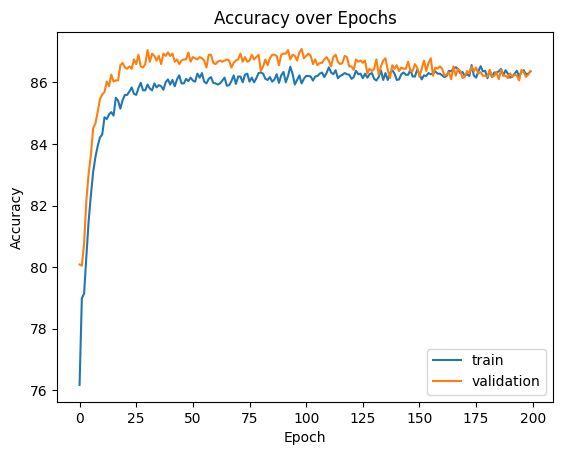

In [151]:
plt.plot(np.array(model_history.history['accuracy'])*100)
plt.plot(np.array(model_history.history['val_accuracy'])*100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','validation'])
plt.title('Accuracy over Epochs')
plt.show()

In [152]:
y_pred = classifier.predict(X_test)
y_pred

63/63 [==============================] - 0s 734us/step


array([[0.08947475],
       [0.46060896],
       [0.22446674],
       ...,
       [0.66472083],
       [0.06148963],
       [0.39249897]], dtype=float32)

In [153]:
# Classify y_pred > 0.5 as 1 and y_pred < 0.5 as 0
y_pred = (y_pred > 0.5).astype(int)
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [154]:
# Computing Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1563,   54],
       [ 221,  162]])

In [155]:
# Accuracy of the model
print(((cm[0][0] + cm[1,1]) * 100) / len(y_test), '% of data classified correctly')

86.25 % of data classified correctly


In [156]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)*100

86.25